In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# initialize model parameters
params = {}
params['m1'] = 0.2704 # mass 1
params['m2'] = 0.2056 # mass 2
params['L1'] = 0.2667 # length 1
params['L2'] = 0.2667 # length 2
params['a1'] = 0.191 # com 1
params['a2'] = 0.1621 # com 2
params['I1'] = 0.003 # inertia 1
params['I2'] = 0.0011 # inertia 2
params['g'] = 9.81 # gravity
print(params)

{'m1': 0.2704, 'm2': 0.2056, 'L1': 0.2667, 'L2': 0.2667, 'a1': 0.191, 'a2': 0.1621, 'I1': 0.003, 'I2': 0.0011, 'g': 9.81}


In [3]:
def ssDoublePendulum(x:np.ndarray, params:dict):
    ''' 
    this function evaluates the differential equation of the double pendulum model in the state-space form
    input:
    x:- state of the double pendulum; [ph1, ph2, dph1, dph2], 
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities
    params:- dictionary consisting of model parameters; m1, m2, L1, L2, a1, a2, I1, I2, g
        m1, m2: mass of the links; 
        L1, L2: length of the links;
        a1, a2: position of the coms of the two links
        I1, I2: link inertias
        g: gravitational acceleration
    output:
    dx:- time derivative of the state x
    '''
    # state variables
    x1 = x[0] 
    x2 = x[1] 
    x3 = x[2] 
    x4 = x[3]

    # parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    a1 = params['a1']
    a2 = params['a2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']
    k1=0
    k2=0

    M = np.array([
        [I1 + L1**2*m2 + a1**2*m1, L1*a2*m2*np.cos(x1-x2)],
        [L1*a2*m2*np.cos(x1-x2), I2 + a2**2*m2]
        ])
    
    # M = np.array([
    #     [1, 0.323*np.cos(x1-x2)],
    #     [1.358*np.cos(x1-x2), 1]
    # ])

    vec = -np.dot(np.linalg.inv(M), np.array([
        (k1+k2)*x3 - k2*x4 + L1*a2*m2*np.sin(x1-x2)*x4**2 - L1*g*m2*np.sin(x1) - a1*g*m1*np.sin(x1),
        -k2*x3 + k2*x4 - L1*a2*m2*np.sin(x1-x2)*x3**2 - a2*g*m2*np.sin(x2)
    ]))
    
    # vec = -np.dot(np.linalg.inv(M), 
    #               np.array([
    #                   0.03235*x3+0.323*x4**2*np.sin(x1-x2)-0.006006*x4-37.97*np.sin(x1),
    #                   -0.02525*x3+0.02525*x4-49.94*np.sin(x2)-1.358*x3**2*np.sin(x1-x2)
    #               ])
    #               )

    dx = np.array([x3, x4, vec[0], vec[1]])

    return dx

def rk4(xCurrent:np.ndarray, dt:float, params:dict):
    ''' 
    this function updates the current state by numerically integrating the continuous state-space dynamics of the pendulum
    input:
    xCurrent:- current state of the double pendulum; [ph1, ph2, dph1, dph2], 
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities

    output:
    xNext:- next state of the double pendulum; [ph1, ph2, dph1, dph2],
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities
    '''
    assert(xCurrent.shape == (4,))
    
    k1 = ssDoublePendulum(xCurrent, params)
    assert(k1.shape == (4,))

    k2 = ssDoublePendulum(xCurrent+dt*k1/2, params)
    assert(k2.shape == (4,))

    k3 = ssDoublePendulum(xCurrent+dt*k2/2, params)
    assert(k3.shape == (4,))

    k4 = ssDoublePendulum(xCurrent+dt*k3, params)
    assert(k4.shape == (4,))
    
    xNext = xCurrent + dt/6*(k1 + 2*k2 + 2*k3 + k4)
    assert(xNext.shape == (4,))

    return xNext

def totalEnergy(x:np.ndarray, params:dict):
    '''
    this function computes the total energy of the double pendulum system, given the state
    inputs:
    x:- current state of the double pendulum; [ph1, ph2, dph1, dph2], 
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities
    
    output:
    E: kinetic energy + potential energy
    '''

    # state variables
    x1 = x[0] # phi_1 
    x2 = x[1] # phi_2
    x3 = x[2] # phi_dot_1
    x4 = x[3] # phi_dot_2

    # parameters
    m1 = params['m1'] 
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    a1 = params['a1']
    a2 = params['a2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']
    k1 = 0
    k2 = 0

    KE = 0.5*(
        m2*((L1*np.cos(x1)*x3+a2*np.cos(x2)*x4)**2 + (L1*np.sin(x1)*x3 + a2*np.sin(x2)*x4)**2)
        ) + 0.5*(
        m1*(a1*x3)**2*(np.cos(x1**2) + np.sin(x1**2))
        ) + 0.5*(I1*x3**2 + I2*x4**2)
    PE = m2*g*(a2*np.cos(x2) + L1*np.cos(x1)) + a1*g*m1*np.cos(x1)
    E = KE + PE

    return np.array([KE, PE, E])

In [102]:
# simulate
tStart = 0.0
tEnd = 10.0
tStep = 0.001
N = int((tEnd-tStart)/tStep)
time = np.linspace(tStart, tEnd, N)
X = np.zeros(shape=(N,4)) # state vector data
Energy = np.zeros(shape=(N,3)) # energy vector data
Energy[0,:] = totalEnergy(X[0,:], params)

# initial condition
X[0,:] = np.array([np.pi+1.2, np.pi-0.6, 0, 0])
for i in range(N-1):
    X[i+1,:] = rk4(X[i,:], tStep, params)
    Energy[i+1] = totalEnergy(X[i+1,:], params)


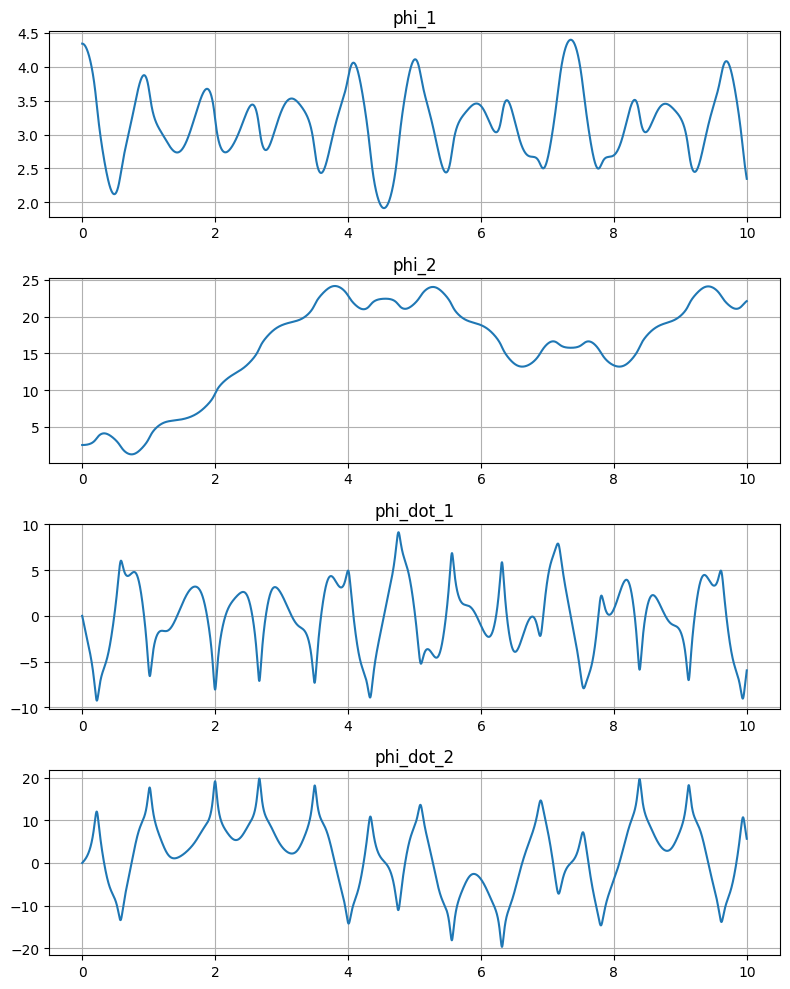

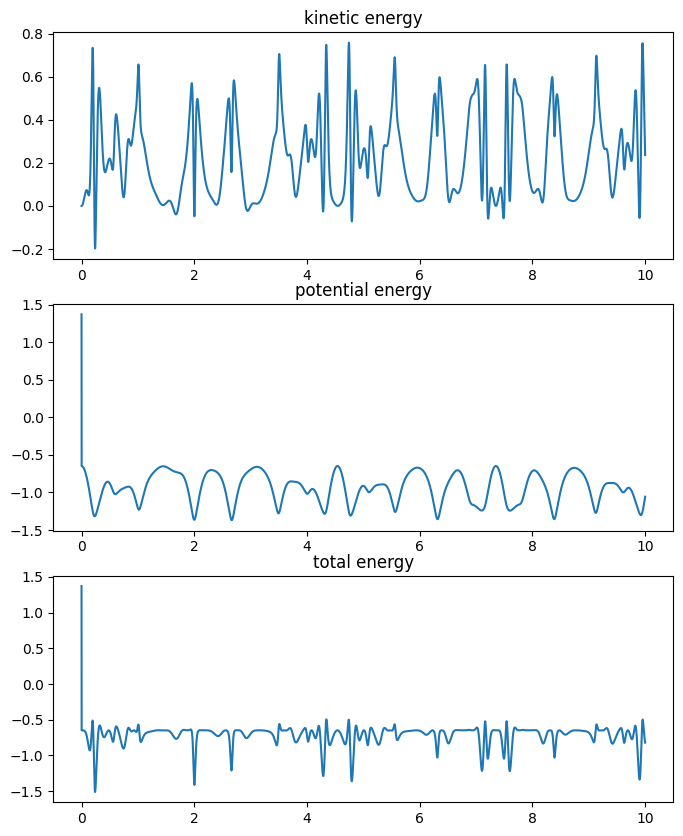

In [103]:
# plot data

# Create a subplot with a size of (4,1)
fig, axs = plt.subplots(4, 1, figsize=(8, 10))

# Plot data
axs[0].plot(time, X[:,0])
axs[0].set_title('phi_1')
axs[0].grid()

axs[1].plot(time, X[:,1])
axs[1].set_title('phi_2')
axs[1].grid()

axs[2].plot(time, X[:,2])
axs[2].set_title('phi_dot_1')
axs[2].grid()

axs[3].plot(time, X[:,3])
axs[3].set_title('phi_dot_2')
axs[3].grid()

plt.tight_layout()

# Create a subplot with a size of (4,1)
fig1, axs1 = plt.subplots(3, 1, figsize=(8, 10))

# Plot data
axs1[0].plot(time, Energy[:,0])
axs1[0].set_title('kinetic energy')

axs1[1].plot(time, Energy[:,1])
axs1[1].set_title('potential energy')

axs1[2].plot(time, Energy[:,2])
axs1[2].set_title('total energy')

plt.show()